In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import dill as pickle



    Only loading the 'en' tokenizer.



## Language modeling

### Data

In [2]:
PATH='data/spooky-author/'

TRN = f'{PATH}train.csv'
TEST = f'{PATH}test.csv'

%ls {PATH}

models/  sample_submission.csv  test/  test.csv  train/  train.csv


In [3]:
trn_df = pd.read_csv(TRN, low_memory=False)
tst_df = pd.read_csv(TEST, low_memory=False)

In [4]:
trn_df.groupby('author')['text'].count()

author
EAP    7900
HPL    5635
MWS    6044
Name: text, dtype: int64

In [5]:
trn_df_eap = trn_df[trn_df['author']=='EAP']
trn_df_hpl = trn_df[trn_df['author']=='HPL']
trn_df_mws = trn_df[trn_df['author']=='MWS']

In [14]:
def save_data(df, set_dir, author=None):
    os.makedirs(f'{PATH}{set_dir}', exist_ok=True)
    if author: os.makedirs(f'{PATH}{set_dir}/{author}', exist_ok=True)
    if author: file = open(f'{PATH}{set_dir}/{author}/{author.lower()}.txt','w') 
    else: file = open(f'{PATH}{set_dir}/all/testData.txt','w')
    
    my_data =""
    for idx, row in df.iterrows():
        data = row['text']
        if my_data == "": my_data = data
        else : my_data += " " + data

    file.write(my_data)
    file.close()
    return my_data

In [15]:
train_data = [save_data(trn_df[trn_df['author']==a], 'train', a) for a in ['EAP', 'HPL', 'MWS']]

In [16]:
test_data = save_data(tst_df, 'test')

## Preprocessing and training

In [17]:
' '.join(spacy_tok(trn_df.text[0]))

'This process , however , afforded me no means of ascertaining the dimensions of my dungeon ; as I might make its circuit , and return to the point whence I set out , without being aware of the fact ; so perfectly uniform seemed the wall .'

In [20]:
PATH='data/spooky-author/'

TRN_PATH = 'train/all/'
VAL_PATH = 'test/all/'

TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'

%ls {PATH}

models/  sample_submission.csv  test/  test.csv  train/  train.csv


In [21]:
TEXT = data.Field(lower=True, tokenize=spacy_tok)

In [22]:
bs=64; bptt=70

In [23]:
FILES = dict(train=TRN_PATH, validation=VAL_PATH, test=VAL_PATH)

In [24]:
md = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=10)

In [25]:
pickle.dump(TEXT, open(f'{PATH}models/TEXT.pkl','wb'))

In [26]:
len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(131, 4930, 1, 595189)

In [27]:
# 'itos': 'int-to-string'
TEXT.vocab.itos[:12]

['<unk>', '<pad>', ',', 'the', 'of', '.', 'and', 'to', 'i', 'a', 'in', 'was']

In [28]:
# 'stoi': 'string to int'
TEXT.vocab.stoi['the']

3

In [29]:
next(iter(md.trn_dl))

(Variable containing:
   131     7   668  ...     51     2    55
   612     0    45  ...   1891    63   964
    30     3    19  ...      0  3447     5
        ...          ⋱          ...       
    92    75    23  ...    212  1413   265
    23  2192  1250  ...     66    32     2
  1667    35    13  ...   4108  1082   317
 [torch.cuda.LongTensor of size 68x64 (GPU 0)], Variable containing:
   612
     0
    45
   ⋮  
     2
    39
     9
 [torch.cuda.LongTensor of size 4352 (GPU 0)])

In [30]:
md.trn_ds[0].text[:12]

['how',
 'lovely',
 'is',
 'spring',
 'as',
 'we',
 'looked',
 'from',
 'windsor',
 'terrace',
 'on',
 'the']

In [31]:
TEXT.numericalize([md.trn_ds[0].text[:12]])

Variable containing:
  131
  612
   30
  783
   21
   40
  223
   28
  709
 4520
   32
    3
[torch.cuda.LongTensor of size 12x1 (GPU 0)]

### Train

In [33]:
em_sz = 100  # size of each embedding vector
nh = 200     # number of hidden activations per layer
nl = 3       # number of layers

In [34]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [35]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
               dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

In [36]:
learner.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[   0.        18.1517   122.35511]                          



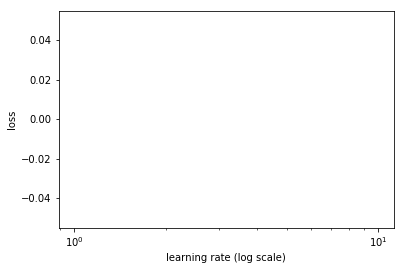

In [37]:
learner.sched.plot()

In [38]:
learner.fit(1e-4, 4, wds=1e-6, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       8.06325  7.94793]                                
[ 1.       7.28453  6.94495]                                
[ 2.       6.84694  6.76323]                                
[ 3.       6.3787   6.15512]                                
[ 4.       6.09413  5.99558]                                
[ 5.       5.99781  5.93771]                                
[ 6.       5.97647  5.93897]                                
[ 7.       5.91631  5.84372]                                
[ 8.       5.86442  5.80631]                                
[ 9.       5.82732  5.78997]                                
[ 10.        5.81012   5.75352]                             
[ 11.        5.79622   5.75591]                            
[ 12.        5.7914    5.75457]                             
[ 13.        5.78935   5.75264]                             
[ 14.        5.78706   5.75253]                             



In [39]:
learner.save_encoder('adam1_enc')

In [40]:
learner.fit(3e-3, 4, wds=1e-6, cycle_len=10, cycle_save_name='adam3_10')

HBox(children=(IntProgress(value=0, description='Epoch', max=40), HTML(value='')))

[ 0.       5.72027  5.55926]                                
[ 1.       5.40284  5.24333]                                
[ 2.       5.14306  5.03352]                                
[ 3.       5.00453  4.91195]                                
[ 4.       4.91787  4.84259]                                
[ 5.       4.85362  4.79389]                                
[ 6.       4.80621  4.76643]                                
[ 7.       4.7764   4.75195]                                
[ 8.       4.76007  4.74504]                                
[ 9.       4.75315  4.74283]                                
[ 10.        4.76076   4.70828]                             
[ 11.        4.69126   4.66024]                             
[ 12.        4.62387   4.62237]                             
[ 13.        4.57503   4.59004]                             
[ 14.        4.53144   4.56939]                             
[ 15.        4.47791   4.55864]                             
[ 16.        4.45631   4

In [41]:
learner.save_encoder('adam3_10_enc')

In [42]:
learner.fit(3e-3, 1, wds=1e-6, cycle_len=20, cycle_save_name='adam3_20')

HBox(children=(IntProgress(value=0, description='Epoch', max=20), HTML(value='')))

[ 0.       4.08389  4.47637]                                
[ 1.       4.16592  4.48179]                                
[ 2.       4.16827  4.46678]                                
[ 3.       4.1382   4.47831]                                
[ 4.       4.13098  4.46923]                                
[ 5.       4.125    4.46917]                                
[ 6.       4.08211  4.48444]                                
[ 7.       4.06109  4.48246]                                
[ 8.       4.04462  4.48224]                                
[ 9.       4.01373  4.49063]                                
[ 10.        4.00015   4.49092]                             
[ 11.        3.98949   4.49412]                             
[ 12.        3.97664   4.49462]                             
[ 13.        3.97429   4.49239]                             
[ 14.        3.9479    4.49575]                             
[ 15.        3.94801   4.49786]                             
[ 16.        3.94979   4

In [43]:
learner.load_cycle('adam3_20', 0)

In [44]:
learner.save_encoder('adam3_20_enc')

In [ ]:
math.exp(4.165)

### Test

We can play around with our language model a bit to check it seems to be working OK. First, let's create a short bit of text to 'prime' a set of predictions. We'll use our torchtext field to numericalize it so we can feed it to our language model.

In [ ]:
m=learner.model
ss=""". So, it wasn't quite was I was expecting, but I really liked it anyway! The best"""
s = [spacy_tok(ss)]
t=TEXT.numericalize(s)
' '.join(s[0])

We haven't yet added methods to make it easy to test a language model, so we'll need to manually go through the steps.

In [ ]:
# Set batch size to 1
m[0].bs=1
# Turn off dropout
m.eval()
# Reset hidden state
m.reset()
# Get predictions from model
res,*_ = m(t)
# Put the batch size back to what it was
m[0].bs=bs

Let's see what the top 10 predictions were for the next word after our short text:

In [ ]:
nexts = torch.topk(res[-1], 10)[1]
[TEXT.vocab.itos[o] for o in to_np(nexts)]

...and let's see if our model can generate a bit more text all by itself!

In [ ]:
print(ss,"\n")
for i in range(50):
    n=res[-1].topk(2)[1]
    n = n[1] if n.data[0]==0 else n[0]
    print(TEXT.vocab.itos[n.data[0]], end=' ')
    res,*_ = m(n[0].unsqueeze(0))
print('...')

### Sentiment

In [45]:
TEXT = pickle.load(open(f'{PATH}models/TEXT.pkl','rb'))

In [46]:
LABEL = data.Field(sequential=False)

In [52]:
class PredictAuthorDataset(torchtext.data.Dataset):
    
    @staticmethod
    def sort_key(ex): return len(ex.text)
    
    def __init__(self, path, text_field, label_field, **kwargs):
        fields = [('text', text_field), ('label', label_field)]
        examples = []
        for label in ['EAP', 'HPL', 'MWS']:
            for fname in iglob(os.path.join(path, label, '*.txt')):
                with open(fname, 'r') as f: text = f.readline()
                examples.append(data.Example.fromlist([text, label], fields))
        super().__init__(examples, fields, **kwargs)
    
    @classmethod
    def splits(cls, text_field, label_field, root='.data',
               train='train', test='test' ,**kwargs):
        return super().splits(
            root, text_field=text_field, label_field=label_field,
            train=train, validation=None, test=test, **kwargs)

In [53]:
splits = PredictAuthorDataset.splits(TEXT, LABEL, PATH, train='train', test='test')

In [54]:
splits

(<__main__.PredictAuthorDataset at 0x7f30b0cc0a58>,
 <__main__.PredictAuthorDataset at 0x7f3138b93f98>)

In [55]:
t = splits[0].examples[0]

In [56]:
t.label, ' '.join(t.text[:16])

('EAP',
 'this process , however , afforded me no means of ascertaining the dimensions of my dungeon')

In [57]:
md2 = TextData.from_splits(PATH, splits, bs)

In [58]:
m3 = md2.get_model(opt_fn, 1500, bptt, emb_sz=em_sz, n_hid=nh, n_layers=nl, 
           dropout=0.1, dropouti=0.4, wdrop=0.5, dropoute=0.05, dropouth=0.3)
m3.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
m3.load_encoder(f'adam3_20_enc')

In [60]:
m3.clip=25.
lrs=np.array([1e-4,1e-3,1e-2])

In [61]:
m3.freeze_to(-1)
m3.fit(lrs/2, 1, metrics=[accuracy])
m3.unfreeze()
m3.fit(lrs, 1, metrics=[accuracy], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

ValueError: __len__() should return >= 0

In [ ]:
m3.fit(lrs, 7, metrics=[accuracy], cycle_len=2, cycle_save_name='imdb2')

In [ ]:
m3.load_cycle('imdb2', 4)

In [ ]:
accuracy(*m3.predict_with_targs())